##### <b>1. Load custom functions</b>

In [45]:
from functions import *
random_state = 1

##### <b>2. Load data and perform EDA (Exploratory Data Analysis)</b>

In [2]:
survey_df = load_data(folder_name="data", file_name="ACME-HappinessSurvey2020.csv")
print(survey_df.head(), "\n")
print(survey_df.info(), "\n")
survey_df.describe()

   Y  X1  X2  X3  X4  X5  X6
0  0   3   3   3   4   2   4
1  0   3   2   3   5   4   3
2  1   5   3   3   3   3   5
3  0   5   4   3   3   3   5
4  0   5   4   3   3   3   5 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126 entries, 0 to 125
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Y       126 non-null    int64
 1   X1      126 non-null    int64
 2   X2      126 non-null    int64
 3   X3      126 non-null    int64
 4   X4      126 non-null    int64
 5   X5      126 non-null    int64
 6   X6      126 non-null    int64
dtypes: int64(7)
memory usage: 7.0 KB
None 



,Y,X1,X2,X3,X4,X5,X6
count,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000
mean,0.547619,4.333333,2.531746,3.309524,3.746032,3.650794,4.253968
std,0.499714,0.800000,1.114892,1.023440,0.875776,1.147641,0.809311
min,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,4.000000,2.000000,3.000000,3.000000,3.000000,4.000000
50%,1.000000,5.000000,3.000000,3.000000,4.000000,4.000000,4.000000
75%,1.000000,5.000000,3.000000,4.000000,4.000000,4.000000,5.000000
max,1.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


The data set is simple - only 126 rows and 6 columns, all integer data type with a range between 0 and 5.<br>
<br>
Since the target variable Y is a categorical variable (0 - unhappy, 1 - happy), convert it accordingly in the data frame.


In [3]:
survey_df["Y"] = survey_df["Y"].astype('category').cat.set_categories([0, 1], ordered=True)

Plot histograms to understand the distribution of each column.

Distribution of target Y and dependent variables:


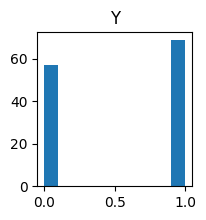

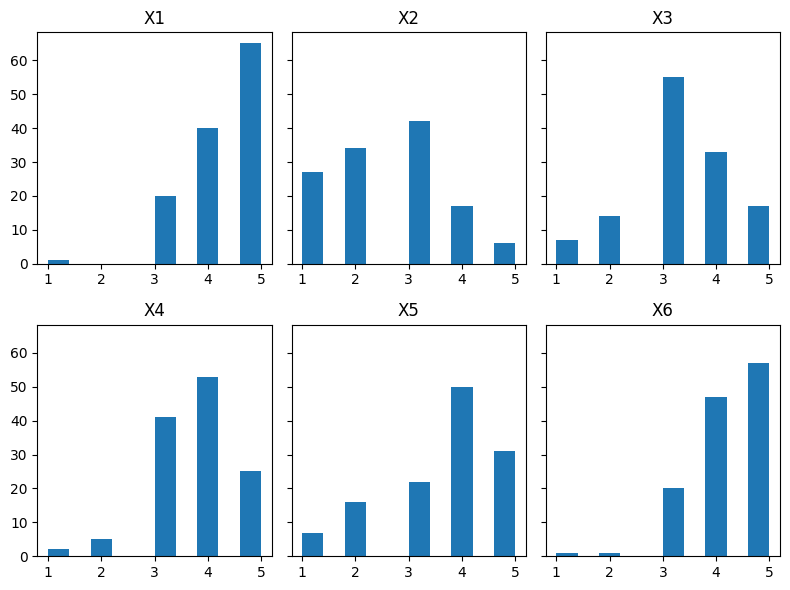

In [4]:
plot_histograms(data=survey_df,
                target="Y", target_figsize=(2,2),
                dependent_layout=(2,3), dependent_figsize=(8,6))

For the target variable Y, the distribution is slightly uneven, with more happy customers in the survey data.<br>
<b>To deal with this class imbalance problem, SMOTE (synthetic minority oversampling technique) will be used in the next stages.</b><br>
<br>
The distribution of each dependent variable is also not uniform. However, it would not matter too much as long as the variables/features can provide predictive power.<br>
To better understand these features, perform Chi-square tests.

##### <b>3. Feature selection</b>

----------------------------------------------------------------------------
----------------------------------------------------------------------------
1. Chi-square test of goodness of fit
----------------------------------------------------------------------------
----------------------------------------------------------------------------
Contingecy table for X1 and Y:
Y    0   1
X1        
1    1   0
3   12   8
4   24  16
5   20  45 

Expected frequencies for X1 and Y:
[[ 0.45238095  0.54761905]
 [ 9.04761905 10.95238095]
 [18.0952381  21.9047619 ]
 [29.4047619  35.5952381 ]]

Testing goodness of fit for X1.

Null hypothesis: There is no significant difference between X1 and the expected frequencies
Chi-square statistic: 18.46153846153846
P-value: 1.0
Failed to reject the null hypothesis
=> X1 is representative of the population at alpha=0.05
--------------------------------------
Contingecy table for X2 and Y:
Y    0   1
X2        
1   13  14
2   13  21
3   19  23
4   10   7
5  

,Chi-square,P-value,Null Hypothesis,Reject Null Hypothesis at alpha=0.05?
Independent Variable,,,,
X1,11.981200,0.007448,X1 and Y are independent of each other,Yes
X2,2.375107,0.667131,X2 and Y are independent of each other,No
X3,4.340259,0.361911,X3 and Y are independent of each other,No
X4,4.648222,0.325332,X4 and Y are independent of each other,No
X5,6.808039,0.146387,X5 and Y are independent of each other,No
X6,8.138426,0.086637,X6 and Y are independent of each other,No


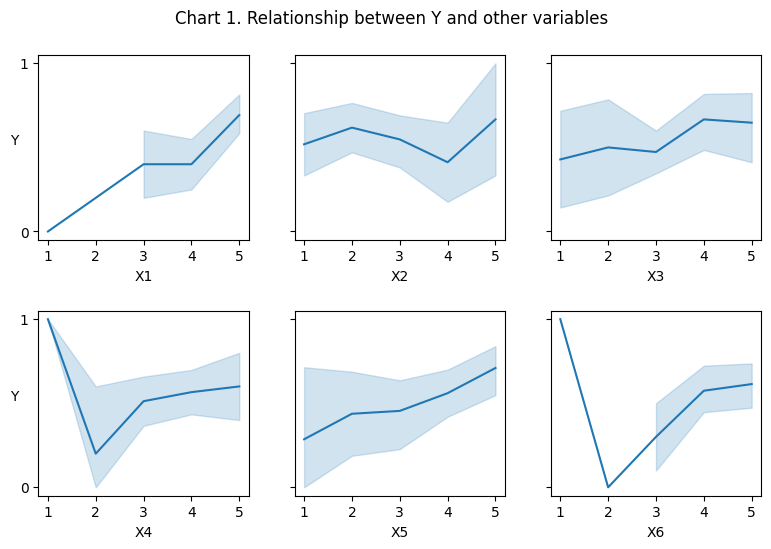

In [5]:
chi_independence_df = run_chi_tests(data=survey_df, target="Y", significance_level=0.05,
                                    plot_row=2, plot_col=3, figsize=(8,5))
print("----------------------------------------------------------------------------")
print("----------------------------------------------------------------------------")
print("2. Chi-square test of independence")
print("----------------------------------------------------------------------------")
print("----------------------------------------------------------------------------")
print("Table 1. Result of Chi-square test of independence (X1-6 and Y)")
chi_independence_df.set_index("Independent Variable")

<b>Chi-square test of goodness of fit</b><br>
- This statistical test is often used to evaluate whether or not sample data is representative of the full population.
- The null hypothesis was that there is no significant difference between a variable and its expected frequencies.
- As we failed to reject the null hypothesis for all 6 dependent variables, we can consider that they are representative of the population at a significance level (or alpha) of 0.05.

<b>Chi-square test of independence</b><br>
- This statistical test is used to evaluate whether or not a difference between observed expected data is due to chance. We can consider a relationship between the variables exists when failing to reject the null hypothesis.
- The null hypothesis was that a dependent variable X# and the target variable Y are independent of each other.
- At a significance level of 0.05, we were able to reject the null hypothesis only for X1.
- If we were to tolerate a higher chance of error by increasing the alpha to 0.1, we would be able to reject the null hypothesis for X6 as well, which would mean that X6 and Y are not independent of each other.
- In summary, X2-X5 are independent of Y, meaning they would not be helpful in predicting Y. Whereas X1 would be helpful in predicting Y at a significance level of 0.05 and X6 as well, at a significance level of 0.1.

<b>Relationship between target Y and each dependent variable</b><br>
- X1 and X5 seem to be good features for training a predictive model based on the line charts above - higher X values (dependent variable) generally correspond to higher Y values (target variable). However, the chi-square test of independence failed to reject the null hypothesis of "X5 and Y are independent of each other" when alpha=0.05.
- On the contrary, it appears that it would be hard to predict Y based on the other X variables as fluctuations are observed from the line charts, which were confirmed by the chi-square test of independence.

<b>Summary and next step</b><br>
- <b>X1 (my order was delivered on time) appears to be the most relevant feature to the target Y (customer satisfaction).</b>
- However, to build a more robust model, it would be reasonable to use at least 2 features rather than discarding 5 out of 6 features, especially because the data are not complex nor big.
- X5 and X6 could be useful in training a predictive model but it is unclear at this stage whether using either or both of them would be better.
- <b>As such, perform the chi-square test of independence again</b>, but this time to test whether there is a relationship between X1 and the other dependent variables <b>to determine what features other than X1 can be useful in model training.</b>

In [6]:
chi_independence_df_X1 = run_chi_tests(data=survey_df.drop(["Y"], axis=1), target="X1", significance_level=0.05,
                                       plot_row=2, plot_col=3, figsize=(8,5), plot=False,
                                       goodness_of_fit_test=False)
print("Table 2. Result of Chi-square test of independence (X1 and X2-6)")
chi_independence_df_X1.set_index("Independent Variable")

Table 2. Result of Chi-square test of independence (X1 and X2-6)


,Chi-square,P-value,Null Hypothesis,Reject Null Hypothesis at alpha=0.05?
Independent Variable,,,,
X2,9.014178,7.017190e-01,X2 and X1 are independent of each other,No
X3,27.601271,6.324615e-03,X3 and X1 are independent of each other,Yes
X4,12.799464,3.837835e-01,X4 and X1 are independent of each other,No
X5,42.710726,2.527299e-05,X5 and X1 are independent of each other,Yes
X6,58.313490,4.573138e-08,X6 and X1 are independent of each other,Yes


X3, X5 and X6 were found to be not independent of X1, meaning they are related to X1.<br>
<br>
With that, we can now try different combinations of the features (i.e. X1, X3, X5 and X6) to see which combination would result in the best prediction accuracy score.<br>
<br>
Before doing so, evaludate different classifiers to choose the base model for the next steps.

##### <b>4. Model selection</b>

First, split the data into train and test.<br>
<br>
As stated above, SMOTE (synthetic minority oversampling technique) will be used for train and test data separately, to handle the class imbalance problem of target Y.<br>
<br>
Train data will be used for model selection, feature engineering, and hyperparameter tuning.<br>
Test data will only be used at the last step to evaluate the fine-tuned model.<br>

In [46]:
X_train, X_test, y_train, y_test = split_data(
    X=survey_df.drop(["Y"], axis=1),
    y=survey_df["Y"],
    test_size=0.24,
    random_state=random_state,
    oversampling=True)

Classifier: LogisticRegression
{'Mean': 0.5844, 'Std': 0.1401, 'Max': 0.875, '75th Percentile': 0.6667, 'Median': 0.5882, '25th Percentile': 0.5, 'Min': 0.0, 'Time elapsed': '00:00:02'} 

Classifier: RandomForestClassifier
{'Mean': 0.581, 'Std': 0.1498, 'Max': 0.875, '75th Percentile': 0.6667, 'Median': 0.5882, '25th Percentile': 0.5, 'Min': 0.0, 'Time elapsed': '00:00:41'} 

Classifier: XGBClassifier
{'Mean': 0.596, 'Std': 0.1315, 'Max': 0.875, '75th Percentile': 0.7059, 'Median': 0.6154, '25th Percentile': 0.5333, 'Min': 0.1818, 'Time elapsed': '00:00:14'} 

XGBClassifier yielded the best mean accuracy score of 0.596


,Mean,Std,Max,75th Percentile,Median,25th Percentile,Min,Time elapsed
XGBClassifier,0.596,0.1315,0.875,0.7059,0.6154,0.5333,0.1818,00:00:14
LogisticRegression,0.5844,0.1401,0.875,0.6667,0.5882,0.5,0.0,00:00:02
RandomForestClassifier,0.581,0.1498,0.875,0.6667,0.5882,0.5,0.0,00:00:41


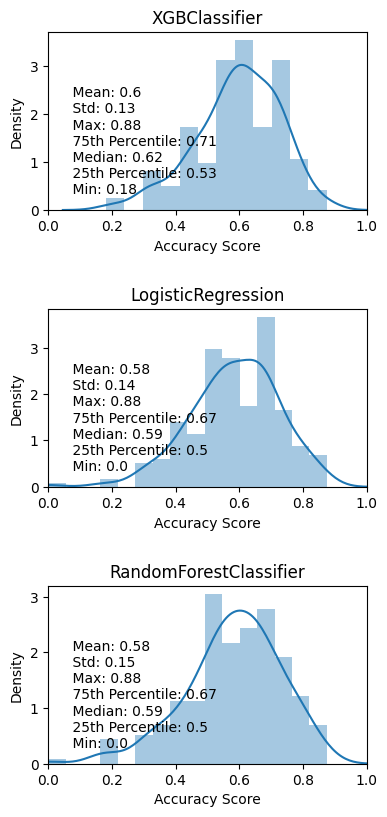

In [8]:
eval_models(X=X_train, y=y_train, n_splits=7, n=30, random_state=random_state)

RandomForestClassifier and XGBClassifier sometimes outperformed LogisticRegresson, but I've decided to use LogisticRegresson as the based model mainly because it was so much faster and the data we have is quite small and simple - thus we might not necessarily need a more complex model for prediction.

Use this classifier as our base model for the later steps. Moving forward, try different combinations of the features (X1, X3, X5 and X6) to see which combination would result in the best prediction accuracy score.

Features: X1, X3
{'Mean': 0.6741, 'Std': 0.1356, 'Max': 1.0, '75th Percentile': 0.7679, 'Median': 0.6856, '25th Percentile': 0.5918, 'Min': 0.2768, 'Time elapsed': '00:00:03'} 

Features: X1, X5
{'Mean': 0.661, 'Std': 0.1333, 'Max': 1.0, '75th Percentile': 0.7589, 'Median': 0.6786, '25th Percentile': 0.5826, 'Min': 0.1607, 'Time elapsed': '00:00:03'} 

Features: X1, X6
{'Mean': 0.6233, 'Std': 0.1395, 'Max': 0.9732, '75th Percentile': 0.7054, 'Median': 0.6327, '25th Percentile': 0.5418, 'Min': 0.1875, 'Time elapsed': '00:00:02'} 

Features: X1, X3, X5
{'Mean': 0.6642, 'Std': 0.1393, 'Max': 0.9821, '75th Percentile': 0.7589, 'Median': 0.6786, '25th Percentile': 0.5804, 'Min': 0.2232, 'Time elapsed': '00:00:02'} 

Features: X1, X3, X6
{'Mean': 0.6523, 'Std': 0.1396, 'Max': 1.0, '75th Percentile': 0.758, 'Median': 0.6562, '25th Percentile': 0.5558, 'Min': 0.2768, 'Time elapsed': '00:00:02'} 

Features: X1, X5, X6
{'Mean': 0.642, 'Std': 0.1331, 'Max': 1.0, '75th Percentile': 0.7321, 'Median

,Mean,Std,Max,75th Percentile,Median,25th Percentile,Min,Time elapsed
"X1, X3",0.6741,0.1356,1.0,0.7679,0.6856,0.5918,0.2768,00:00:03
"X1, X3, X5",0.6642,0.1393,0.9821,0.7589,0.6786,0.5804,0.2232,00:00:02
"X1, X5",0.661,0.1333,1.0,0.7589,0.6786,0.5826,0.1607,00:00:03
"X1, X3, X6",0.6523,0.1396,1.0,0.758,0.6562,0.5558,0.2768,00:00:02
"X1, X5, X6",0.642,0.1331,1.0,0.7321,0.6562,0.5625,0.1607,00:00:02
"X1, X6",0.6233,0.1395,0.9732,0.7054,0.6327,0.5418,0.1875,00:00:02


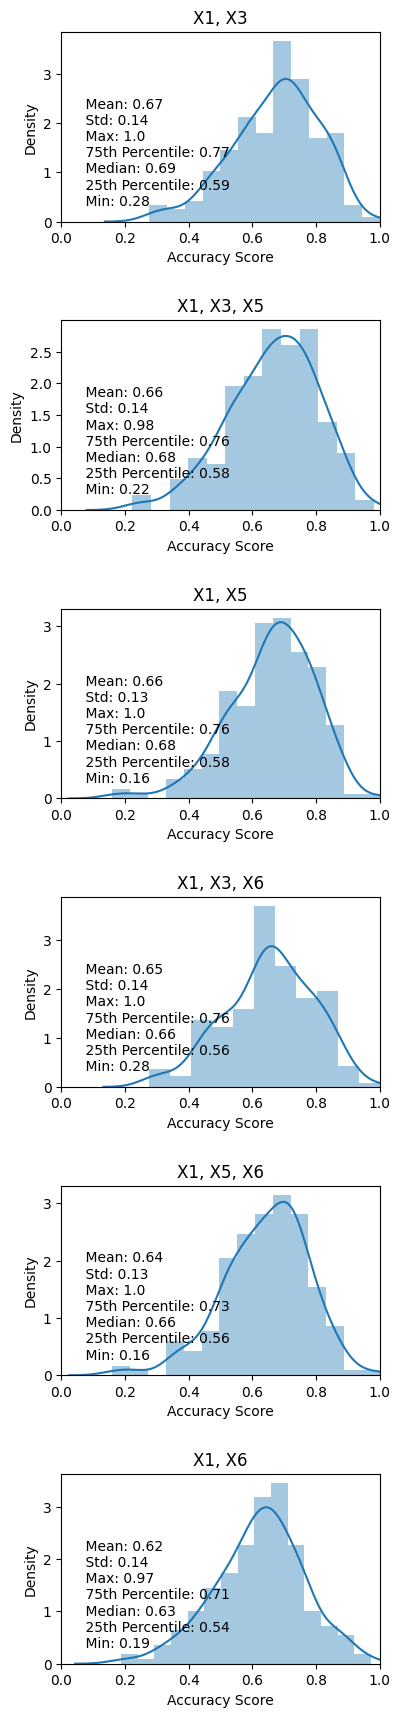

In [14]:
eval_feature_combinations(X=X_train, y=y_train, n_splits=7, n=30, random_state=random_state,
                        classifier=LogisticRegression(random_state=random_state))

<b>X1 and X3</b> resulted in the best mean prediction accuracy score, thus the other features will not be used from now on.<br>
<br>
Re-define X_train and X_test with the best features combination for the later steps.


In [47]:
X_train_reduced = X_train[["X1", "X3"]]
X_test_reduced = X_test[["X1", "X3"]]

##### <b>5. Feature augmentation</b>

With the three features, try different data augmentation/transformation techniques that will create new features out of the existing features to see whether they improve prediction accuracy.

Transformer: SkewedChi2Sampler(random_state=1)
{'Mean': 0.6696, 'Std': 0.1313, 'Max': 0.9286, '75th Percentile': 0.7589, 'Median': 0.6875, '25th Percentile': 0.5826, 'Min': 0.2679, 'Time elapsed': '00:00:04'} 

Transformer: PolynomialCountSketch(random_state=1)
{'Mean': 0.6795, 'Std': 0.1323, 'Max': 1.0, '75th Percentile': 0.7679, 'Median': 0.7009, '25th Percentile': 0.5982, 'Min': 0.3214, 'Time elapsed': '00:00:03'} 

Transformer: AdditiveChi2Sampler()
{'Mean': 0.6357, 'Std': 0.1305, 'Max': 0.9286, '75th Percentile': 0.7232, 'Median': 0.6429, '25th Percentile': 0.5612, 'Min': 0.2232, 'Time elapsed': '00:00:03'} 

Transformer: RBFSampler(random_state=1)
{'Mean': 0.6815, 'Std': 0.1429, 'Max': 0.9464, '75th Percentile': 0.7924, 'Median': 0.7054, '25th Percentile': 0.5893, 'Min': 0.25, 'Time elapsed': '00:00:02'} 

Transformer: PolynomialFeatures()
{'Mean': 0.674, 'Std': 0.132, 'Max': 1.0, '75th Percentile': 0.7679, 'Median': 0.692, '25th Percentile': 0.5893, 'Min': 0.3214, 'Time elapsed'

,Mean,Std,Max,75th Percentile,Median,25th Percentile,Min,Time elapsed
RBFSampler(random_state=1),0.6815,0.1429,0.9464,0.7924,0.7054,0.5893,0.25,00:00:02
PolynomialCountSketch(random_state=1),0.6795,0.1323,1.0,0.7679,0.7009,0.5982,0.3214,00:00:03
PolynomialFeatures(),0.674,0.132,1.0,0.7679,0.692,0.5893,0.3214,00:00:04
SkewedChi2Sampler(random_state=1),0.6696,0.1313,0.9286,0.7589,0.6875,0.5826,0.2679,00:00:04
AdditiveChi2Sampler(),0.6357,0.1305,0.9286,0.7232,0.6429,0.5612,0.2232,00:00:03


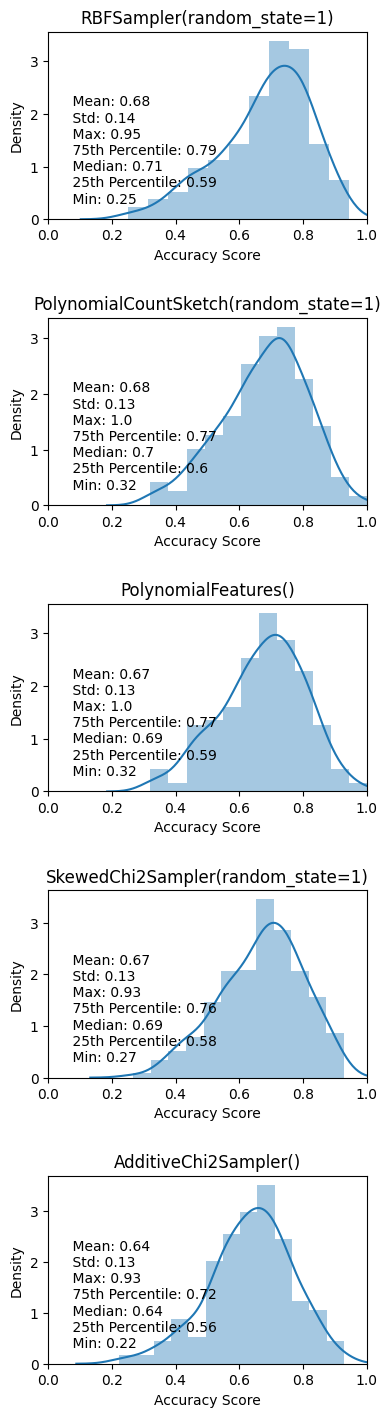

In [13]:
eval_transformers(X=X_train_reduced, y=y_train, n_splits=7, n=30, random_state=random_state,
                classifier=LogisticRegression(random_state=random_state))

# the best was RBFSampler -> what it is and why it performs well with the data we have?

As we found the mean accuracy scores improved with the transformers, use the best performing transformer for the next steps.

In [48]:
transformer=RBFSampler(random_state=random_state)
X_train_transformed = transformer.fit_transform(X_train_reduced)
X_test_transformed = transformer.transform(X_test_reduced)

##### <b>6. Dimensionality reduction</b>
Now we have more features due to the feature augmentation process, try different dimensionality reduction techniques to see if they help improve accuracy score.

Decomposer: PCA(random_state=1)
{'Mean': 0.6582, 'Std': 0.1363, 'Max': 0.9592, '75th Percentile': 0.75, 'Median': 0.6786, '25th Percentile': 0.5625, 'Min': 0.2768, 'Time elapsed': '00:00:02'} 

Decomposer: KernelPCA(random_state=1)
{'Mean': 0.6607, 'Std': 0.1391, 'Max': 0.9592, '75th Percentile': 0.7589, 'Median': 0.6786, '25th Percentile': 0.5647, 'Min': 0.2679, 'Time elapsed': '00:00:02'} 

Decomposer: IncrementalPCA()
{'Mean': 0.6588, 'Std': 0.1373, 'Max': 0.9592, '75th Percentile': 0.75, 'Median': 0.6786, '25th Percentile': 0.5647, 'Min': 0.2679, 'Time elapsed': '00:00:02'} 

Decomposer: TruncatedSVD()
{'Mean': 0.651, 'Std': 0.1402, 'Max': 0.9286, '75th Percentile': 0.75, 'Median': 0.6562, '25th Percentile': 0.5555, 'Min': 0.2054, 'Time elapsed': '00:00:01'} 

Decomposer: FeatureAgglomeration()
{'Mean': 0.5273, 'Std': 0.1631, 'Max': 0.9107, '75th Percentile': 0.6429, 'Median': 0.5268, '25th Percentile': 0.4196, 'Min': 0.0714, 'Time elapsed': '00:00:01'} 

KernelPCA(random_state=1) 

,Mean,Std,Max,75th Percentile,Median,25th Percentile,Min,Time elapsed
KernelPCA(random_state=1),0.6607,0.1391,0.9592,0.7589,0.6786,0.5647,0.2679,00:00:02
IncrementalPCA(),0.6588,0.1373,0.9592,0.75,0.6786,0.5647,0.2679,00:00:02
PCA(random_state=1),0.6582,0.1363,0.9592,0.75,0.6786,0.5625,0.2768,00:00:02
TruncatedSVD(),0.651,0.1402,0.9286,0.75,0.6562,0.5555,0.2054,00:00:01
FeatureAgglomeration(),0.5273,0.1631,0.9107,0.6429,0.5268,0.4196,0.0714,00:00:01


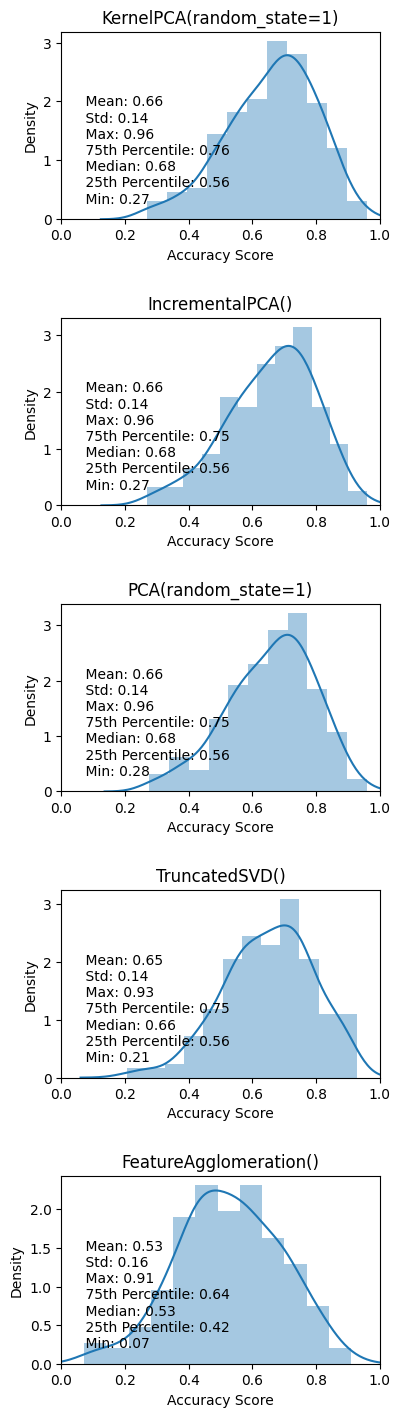

In [13]:
eval_decomposers(X=X_train_transformed, y=y_train, n_splits=7, n=30, random_state=random_state,
                classifier=LogisticRegression(random_state=random_state))

Decomposers were not helpful in improving accuracy, thus will not be used in the next steps.<br>
<br>
Next is hyperparameter tuning for the classifier.

##### <b>7. Hyperparameter tuning & evaluate the tuned model using test data</b>

In [49]:
params = {
    "penalty": ["l1", "l2", "elasticnet", None],
    "tol": [10.0 ** n for n in np.arange(-10, 0, 1)],
    "C": [10.0 ** n for n in np.arange(-10, 0, 1)],
    "fit_intercept": [True, False],
    "class_weight": ["balanced", None],
    "solver": ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
    "max_iter": np.arange(10, 200, 10),
}
best_search = hyperparameter_tuning_and_evaluation(
    n_iter=30, cv=7, random_state=random_state,
    X_train=X_train_transformed, y_train=y_train,
    X_test=X_test_transformed, y_test=y_test,
    params=params
)

n_iter: 30, cv: 7, best_score: 0.7, test_score: 0.74


##### <b>9. Save the best performing model for future use</b>

In [50]:
import pickle

best_model = best_search.best_estimator_

# save the best model
pickle.dump(best_model, open("best_model.sav", 'wb'))

# load the best model
loaded_model = pickle.load(open("best_model.sav", 'rb'))
loaded_model.score(X_test_transformed, y_test)

0.7352941176470589

##### <b>10. Conclusion</b>

learning points, insights, future work, etc.

likely because of the small size of the data, small changes to test_size, n_iter, and cv could make huge differences.
also for the scoring metric in the cross_val_score function used in model-, feature-, transformer-, and decomposer-evaluations, 'roc_auc' returned the best results, whereas 'f1' resulted in the best model through the RandomizedSearchCV used in hyperparameter tuning.
why?